# Reverse Engineering 1D Cellular Automata Rules
#### Author: Fiyinfoluwa Dideoluwa

This project explores Elementary Cellular Automata (ECA) simple 1D systems where each cell evolves over time based on a local 3-cell neighborhood and a deterministic rule (0-255). The goal includes:

1. Simulate and analyze the behavior of all 256 ECA rules.

2. Reverse engineer the rule number from a given CA grid by observing how states change over time.

### Steps

- Creating CA simulations using user-defined or random initial states.

- Measuring the frequency of active cells (1s) and clustering rules based on this behavior.

- Visualizing the spatial-temporal evolution of different rules.

- Implementing a rule inference algorithm that reconstructs the original CA rule from the generated grid, validating its accuracy and robustness across multiple rule types.

In [1]:
# import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sympy.abc import epsilon

In [2]:
def get_rule_table(rule_number):
    """
    Given a rule number (0–255), return a dictionary mapping each 3-bit neighborhood
    pattern (as string) to its binary outcome according to that rule.
    """
    binary_repr = f"{rule_number:08b}"  # convert rule number to 8-bit binary string (e.g 30 is converted to 00011110)
    keys = ['111', '110', '101', '100', '011', '010', '001', '000']  # These are all the possible 3-bit patterns in the order of most to least significant (as per Wolfram’s convention).
    return {k: int(b) for k, b in zip(keys, binary_repr)} # map each pattern to each binary output and return the dictionary


In [3]:
def run_ca(rule_number, grid_size, time_steps, init_mode):
    """
    Simulate a 1D cellular automaton (CA) for a given rule number.
    Parameters:
        rule_number: int, the CA rule (0–255)
        grid_size: number of cells per row
        time_steps: number of time steps to simulate
        init_mode: 'random' or 'single' to set initial state
    """
    # get corresponding rule table for a given rule number
    rule = get_rule_table(rule_number)
    # create empty grid and initialize with zeros
    grid = np.zeros((time_steps, grid_size), dtype=int)

    
    # Initialize the first row of the cellular automaton grid
    if isinstance(init_mode, str):  # If the user passed a string for init_mode
        if init_mode == 'single':
            # Set only the center cell in the first row to 1, rest remain 0
            grid[0, grid_size // 2] = 1
        elif init_mode == 'random':
            # Randomly assign each cell in the first row a value of 0 or 1
            grid[0] = np.random.choice([0, 1], size=grid_size)
        else:
            # The string is not recognized
            raise ValueError("Invalid init_mode string. Use 'single', 'random', or provide a custom array.")
    
    # If the user initializes a custom 1D CA array
    elif isinstance(init_mode, (list, np.ndarray)):
        # Convert the input to a NumPy array of integers (0s and 1s)
        custom_init = np.array(init_mode, dtype=int)
        
        # Check that the custom pattern is exactly the same length as the grid width
        if custom_init.shape[0] != grid_size:
            raise ValueError(f"Custom initial state must have length {grid_size}.")
        
        # Assign the custom pattern as the first row of the grid
        grid[0] = custom_init
    
    else:
        # If init_mode is neither a recognized string nor an array-like input
        raise TypeError("init_mode must be a string ('single' or 'random') or a 1D array-like object.")

    
    # Evolve the CA over time
    for t in range(1, time_steps):  # t goes from 1 to time_steps-1 (since row 0 is initialized already).
        for i in range(1, grid_size - 1):  # For each cell i (excluding the boundary cells i.e. first and last cells)
            neighborhood = ''.join(map(str, grid[t-1, i-1:i+2])) #join the 3-bit neighborhood patterns using stride = 1) from the previous grid
            grid[t, i] = rule[neighborhood]  # looks up the next state of the centre of the neighborhood from its rule and stores the new value in the next grid, t.
    return grid

In [4]:
def get_frequency_vector(grid):
    """
    Compute the frequency vector of 1s for a CA grid by averaging over time.
    Returns:
        1D NumPy array of frequencies for each cell.
    """
    return np.mean(grid, axis=0)

In [5]:
# Distance-based Neighbor Analysis
def find_neighbors(vectors, epsilon=0.3):
    """
    Compute Euclidean distance neighbors between all pairs of vectors.
    A neighbor is any other vector whose distance <= epsilon.
    Returns:
        Dictionary mapping each index to a set of neighbor indices.
    """
    distances = pairwise_distances(vectors, metric="euclidean")
    neighbors = {}
    for i in range(len(distances)):
        neighbors[i] = set(np.where(distances[i] <= epsilon)[0]) - {i} # neighbors excluding self
    return neighbors


In [6]:
def check_symmetric_relations(neighbors):
    """
    Check if similarity-based neighbor sets are symmetric.
    Returns:
        (symmetric: bool, asym_pairs: list of asymmetric pairs)
    """
    symmetric = True
    asym_pairs = []
    for i, neigh_i in neighbors.items():
        for j in neigh_i:
            set_i = neigh_i | {i}
            set_j = neighbors[j] | {j}
            if set_i != set_j:
                symmetric = False
                asym_pairs.append((i, j))
    return symmetric, asym_pairs

In [7]:
# Plot the frequency vector for a specific rule.
def plot_frequency_vector(rule_num, frequency_vector):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(frequency_vector)), frequency_vector, label=f"Rule {rule_num}")
    plt.title(f"Frequency Vector for Rule {rule_num}")
    plt.xlabel("Position")
    plt.ylabel("Frequency of 1s")
    plt.grid(True)
    plt.legend()
    plt.show()

In [10]:
def process_initial_state(init_state, n_clusters=4, epsilon=0.3):
    """
    For a given initial state, generate frequency vectors for all 256 rules,
    cluster them, visualize PCA, and check symmetry relations.
    Returns:
        frequency_vectors: NumPy array of shape (256, grid_size)
        labels: NumPy array of cluster labels
    """
    frequency_vectors = []
    # Loop over all 256 rules
    for rule_num in range(256):
        grid = run_ca(rule_num, grid_size=20, time_steps=200, init_mode=init_state)
        freq_vector = get_frequency_vector(grid)
        frequency_vectors.append(freq_vector)

    frequency_vectors = np.array(frequency_vectors)

    # Apply Kmeans Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(frequency_vectors)

    # PCA Dimensionality Reduction
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(frequency_vectors)

    # Visualization
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=labels, palette='tab10')
    plt.title("PCA of Frequency Vectors (Initial State)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

    # Symmetry Check
    neighbors = find_neighbors(frequency_vectors, epsilon=epsilon)
    symmetric, asym_pairs = check_symmetric_relations(neighbors)
    if symmetric:
        print("All neighbor sets are symmetric.")
    else:
        print(f"Found {len(asym_pairs)} asymmetric pairs (epsilon={epsilon}).")

    return frequency_vectors, labels




=== Processing Initial State 1 ===


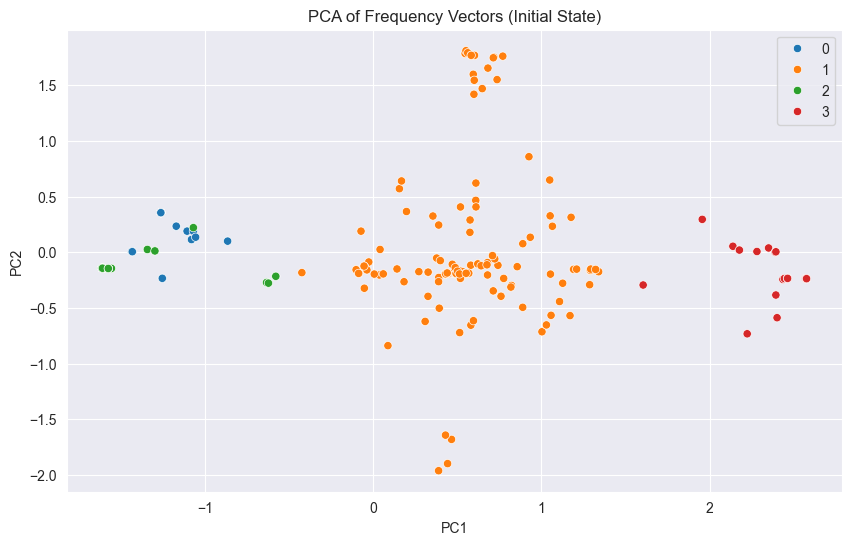

Found 788 asymmetric pairs (epsilon=0.3).

=== Processing Initial State 2 ===


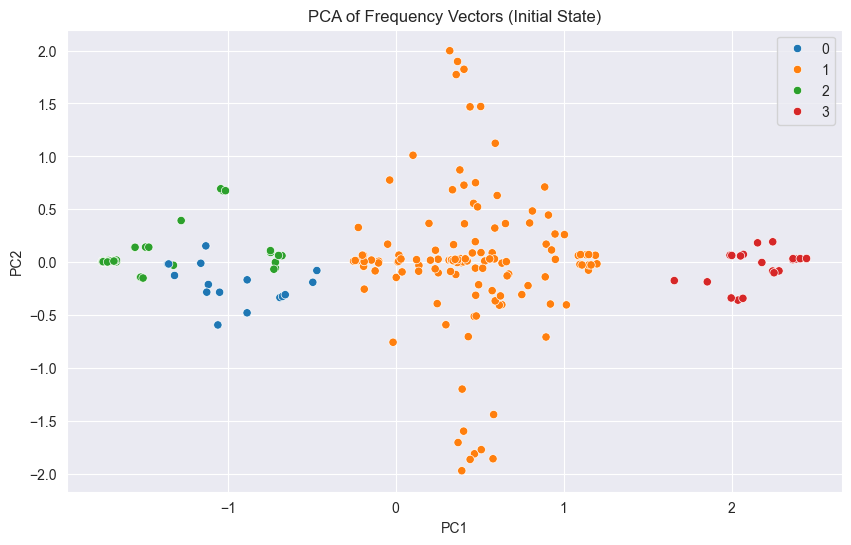

Found 468 asymmetric pairs (epsilon=0.3).

=== Processing Initial State 3 ===


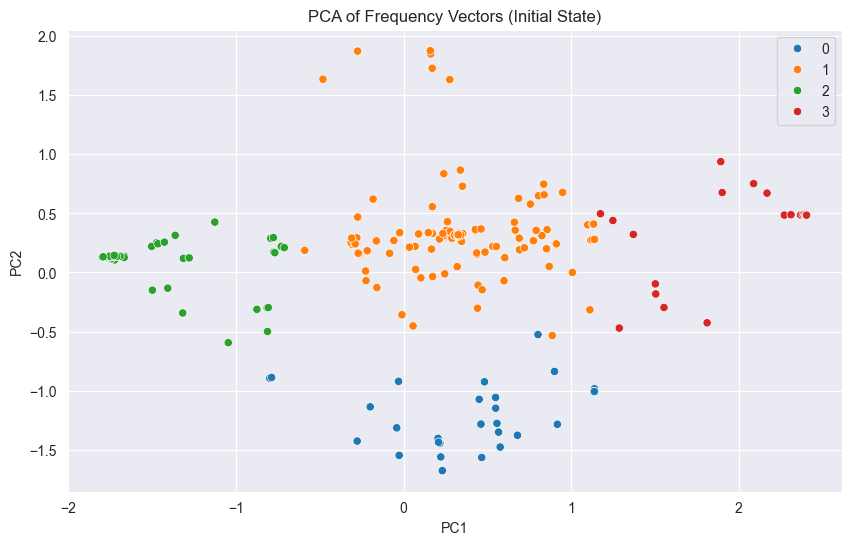

Found 282 asymmetric pairs (epsilon=0.3).


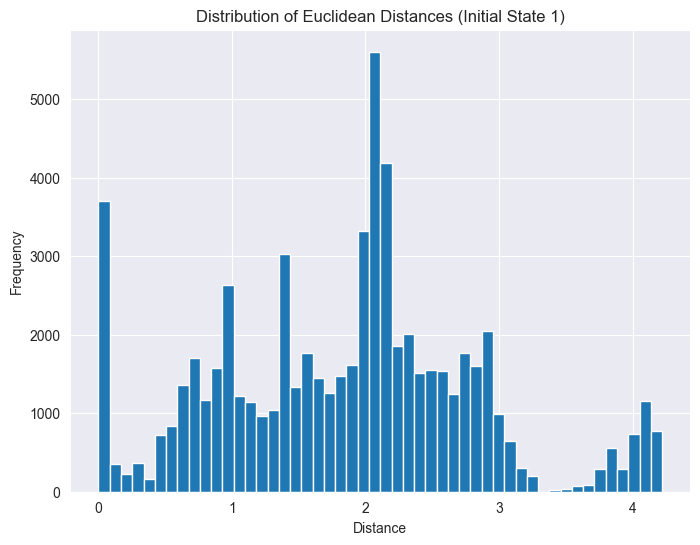

In [11]:
# Define initial states
init_states = [
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
     0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
     0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
     0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
]

# Process each initial state
all_results = []
for idx, init in enumerate(init_states):
    print(f"\n=== Processing Initial State {idx+1} ===")
    freq_vectors, labels = process_initial_state(init, n_clusters=4, epsilon=0.3)
    all_results.append({
        "init_state_index": idx,
        "frequency_vectors": freq_vectors,
        "labels": labels
    })

# Histogram of Euclidean Distances for one initial state to help choose epsilon
distances = pairwise_distances(all_results[0]["frequency_vectors"], metric="euclidean")
plt.figure(figsize=(8,6))
plt.hist(distances.flatten(), bins=50)
plt.title("Distribution of Euclidean Distances (Initial State 1)")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [12]:
# For each rule, count how many different clusters it was assigned to
consistency_counts = []
for rule_idx in range(256):
    labels_per_state = [result["labels"][rule_idx] for result in all_results]
    unique_labels = set(labels_per_state)
    consistency_counts.append(len(unique_labels))

# Summary output
print("\nCluster Consistency Summary:")
print(f"Mean number of unique labels per rule: {np.mean(consistency_counts):.2f}")
print(f"Number of rules always assigned to the same cluster: {sum(c==1 for c in consistency_counts)} / 256")

# List unstable rules
unstable_rules = [i for i, c in enumerate(consistency_counts) if c > 1]
print("\nUnstable rules (assigned to >1 cluster):", unstable_rules)



Cluster Consistency Summary:
Mean number of unique labels per rule: 1.22
Number of rules always assigned to the same cluster: 202 / 256

Unstable rules (assigned to >1 cluster): [5, 6, 13, 15, 22, 28, 29, 30, 36, 46, 69, 70, 71, 77, 78, 79, 84, 92, 93, 95, 100, 102, 109, 110, 111, 133, 134, 135, 141, 143, 156, 157, 164, 174, 182, 183, 197, 198, 199, 200, 202, 205, 206, 207, 212, 216, 220, 221, 228, 230, 232, 234, 238, 248]


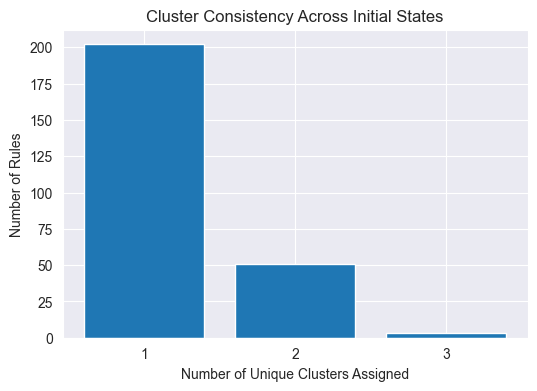

In [13]:
# Histogram visualization of Cluster consistency
plt.figure(figsize=(6,4))
plt.hist(consistency_counts, bins=[0.5,1.5,2.5,3.5], rwidth=0.8)
plt.xticks([1,2,3])
plt.xlabel("Number of Unique Clusters Assigned")
plt.ylabel("Number of Rules")
plt.title("Cluster Consistency Across Initial States")
plt.grid(True)
plt.show()


In [14]:
num_random_states = 500    # Number of random initial states to generate
grid_size = 20             # Number of cells in each CA row

# Generate 500 random initial states (each with a random array of 0s and 1s)
random_initial_states = [
    np.random.choice([0,1], size=grid_size)
    for _ in range(num_random_states)
]

# Parameters
n_clusters = 4  # Number of clusters for KMeans
epsilon = 0.3

# Initialize an array to store labels for each rule and each initial state
all_labels_matrix = np.zeros((256, num_random_states), dtype=int)

print("\nProcessing 500 random initial states...")

# Loop over each random initial state
for idx, init_state in enumerate(random_initial_states):
    frequency_vectors = []
    # For each of the 256 elementary CA rules:
    for rule_num in range(256):
        # Simulate the CA with this initial state
        grid = run_ca(rule_num, grid_size=grid_size, time_steps=200, init_mode=init_state)
        
        # Compute the mean frequency vector (averaged over time steps) and store it
        freq_vector = get_frequency_vector(grid)
        frequency_vectors.append(freq_vector)

    frequency_vectors = np.array(frequency_vectors)  # Convert to numpy array

    # Cluster the frequency vectors into 4 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(frequency_vectors)

    # Store labels for this initial state
    all_labels_matrix[:, idx] = labels

    # Print progress at every 50 iterations
    if (idx + 1) % 50 == 0:
        print(f"Processed {idx + 1} / {num_random_states} initial states.")

print("Done.")



Processing 500 random initial states...
Processed 50 / 500 initial states.
Processed 100 / 500 initial states.
Processed 150 / 500 initial states.
Processed 200 / 500 initial states.
Processed 250 / 500 initial states.
Processed 300 / 500 initial states.
Processed 350 / 500 initial states.
Processed 400 / 500 initial states.
Processed 450 / 500 initial states.
Processed 500 / 500 initial states.
Done.


In [15]:
# Compute unique label counts per rule
consistency_counts = []
for rule_idx in range(256):
    unique_labels = set(all_labels_matrix[rule_idx, :])
    consistency_counts.append(len(unique_labels))


In [16]:
# Print summary statistics
print("\n=== Cluster Consistency Over 500 Random Initial States ===")
print(f"Mean number of unique labels per rule: {np.mean(consistency_counts):.2f}")
print(f"Rules always assigned to the same cluster: {sum(c==1 for c in consistency_counts)} / 256")
print(f"Rules assigned to 2 clusters: {sum(c==2 for c in consistency_counts)}")
print(f"Rules assigned to 3 clusters: {sum(c==3 for c in consistency_counts)}")
print(f"Rules assigned to all 4 clusters: {sum(c==4 for c in consistency_counts)}")



=== Cluster Consistency Over 500 Random Initial States ===
Mean number of unique labels per rule: 3.62
Rules always assigned to the same cluster: 0 / 256
Rules assigned to 2 clusters: 0
Rules assigned to 3 clusters: 97
Rules assigned to all 4 clusters: 159


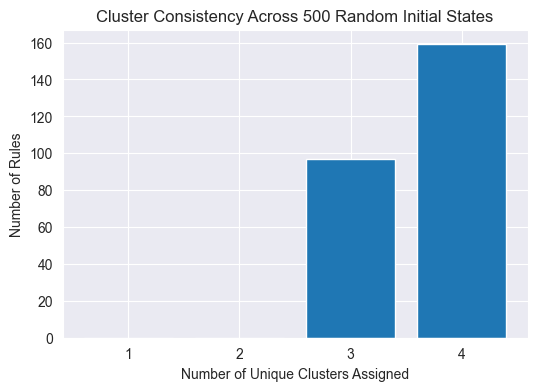

In [17]:
# Histogram visualization of Cluster consistency 
plt.figure(figsize=(6,4))
plt.hist(consistency_counts, bins=[0.5,1.5,2.5,3.5,4.5], rwidth=0.8)
plt.xticks([1,2,3,4])
plt.xlabel("Number of Unique Clusters Assigned")
plt.ylabel("Number of Rules")
plt.title("Cluster Consistency Across 500 Random Initial States")
plt.grid(True)
plt.show()
